In [20]:
! pip install tensorflow

In [21]:
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [22]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [23]:
stop_words = set(stopwords.words("english"))


In [24]:
df = pd.read_csv('/content/cellula_toxic_data.csv')
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


`check if is there any null values`

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   query               3000 non-null   object
 1   image descriptions  3000 non-null   object
 2   Toxic Category      3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [26]:
df["text"] = df["query"] + " " + df["image descriptions"]
df = df.drop(['query', 'image descriptions'], axis=1)
df["text"][1]

"What's the best way to keep criminal elements out of your workplace? A family enjoying a picnic in the park."

In [27]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)
df["text"] = df["text"].apply(preprocess_text)


In [28]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["Toxic Category"])
df.drop('Toxic Category', axis=1, inplace=True)
df["label"][1]


np.int64(3)

In [29]:
num_classes = df["label"].nunique()
num_classes

9

In [30]:
df.label.value_counts()

,count
label,
3,995
7,792
2,301
8,274
6,196
4,115
5,114
1,110
0,103


In [31]:
X = df["text"]
y = df["label"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


`Tokenization`

In [33]:
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

`Padding`

In [34]:
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

`Class Weights`

In [35]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(3.252032520325203),
 1: np.float64(3.0303030303030303),
 2: np.float64(1.1065006915629323),
 3: np.float64(0.33500837520938026),
 4: np.float64(2.898550724637681),
 5: np.float64(2.93040293040293),
 6: np.float64(1.6985138004246285),
 7: np.float64(0.4206098843322818),
 8: np.float64(1.21765601217656)}

### `Models`

##### `LSTM Model`

In [36]:
vocab_size = 5000
embedding_dim = 128

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_shape=(max_len,)
    ),
    LSTM(256, return_sequences=True),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,353 (4.89 MB)

 Trainable params: 1,281,353 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    validation_data=(X_test_pad, y_test_cat)
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.1470 - loss: 2.2144 - val_accuracy: 0.0350 - val_loss: 2.1752
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.0655 - loss: 2.2458 - val_accuracy: 0.0383 - val_loss: 2.1935
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1053 - loss: 2.1876 - val_accuracy: 0.0383 - val_loss: 2.1897
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1391 - loss: 2.2231 - val_accuracy: 0.1017 - val_loss: 2.1977
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0953 - loss: 2.1988 - val_accuracy: 0.0367 - val_loss: 2.1818
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1284 - loss: 2.1985 - val_accuracy: 0.0383 - val_loss: 2.2106
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0857 - loss: 2.2071 - val_accuracy: 0.0383 - val_loss: 2.2014
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1097 - loss: 2.2439 - val_accuracy: 0.2633 - 

In [39]:
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=le.classes_
))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
                           precision    recall  f1-score   support

Child Sexual Exploitation       0.00      0.00      0.00        21
                Elections       0.20      1.00      0.34        22
       Non-Violent Crimes       0.00      0.00      0.00        60
                     Safe       0.00      0.00      0.00       199
       Sex-Related Crimes       0.00      0.00      0.00        23
      Suicide & Self-Harm       0.30      0.57      0.39        23
           Unknown S-Type       0.11      0.05      0.07        39
           Violent Crimes       0.21      0.03      0.05       158
                   unsafe       0.13      0.96      0.23        55

                 accuracy                           0.16       600
                macro avg       0.11      0.29      0.12       600
             weighted avg       0.09      0.16      0.06       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


`Inference Example`

In [40]:
test_text = ["How do terrorist organizations fund attacks Police tape at night"]
seq = tokenizer.texts_to_sequences(test_text)
padded = pad_sequences(seq, maxlen=max_len, padding="post")  # FIXED: Use max_len variable

prediction = model.predict(padded)
predicted_label = le.inverse_transform([prediction.argmax()])

print(f"Test text: {test_text[0]}")
print(f"Predicted category: {predicted_label[0]}")
print(f"Prediction probabilities: {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Test text: How do terrorist organizations fund attacks Police tape at night
Predicted category: Suicide & Self-Harm
Prediction probabilities: [0.17164004 0.15698206 0.02344212 0.03477408 0.20439774 0.21956283
 0.13658515 0.02142567 0.0311903 ]


##### `Bidirectional LSTM  Model`

In [41]:
vocab_size = 5000
embedding_dim = 128

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_shape=(max_len,)
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,681 (4.08 MB)

 Trainable params: 1,068,681 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(
    X_train_pad,
    y_train_cat,  # FIXED: Use categorical labels
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    validation_data=(X_test_pad, y_test_cat)  # FIXED: Use categorical labels
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.2733 - loss: 1.9783 - val_accuracy: 0.8650 - val_loss: 0.6021
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8230 - loss: 0.6779 - val_accuracy: 0.9133 - val_loss: 0.2289
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9249 - loss: 0.1822 - val_accuracy: 0.9117 - val_loss: 0.3109
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9375 - loss: 0.1660 - val_accuracy: 0.9433 - val_loss: 0.1883
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9606 - loss: 0.1440 - val_accuracy: 0.9533 - val_loss: 0.1973
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9962 - loss: 0.0376 - val_accuracy: 0.9233 - val_loss: 0.2231
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9917 - loss: 0.0294 - val_accuracy: 0.9483 - val_loss: 0.2349
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9997 - loss: 0.0101 - val_accuracy: 0.9533 - 

In [44]:
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=le.classes_
))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       1.00      1.00      1.00        60
                     Safe       0.90      0.95      0.93       199
       Sex-Related Crimes       0.96      1.00      0.98        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.72      0.46      0.56        39
           Violent Crimes       0.99      1.00      1.00       158
                   unsafe       1.00      1.00      1.00        55

                 accuracy                           0.95       600
                macro avg       0.95      0.94      0.94       600
             weighted avg       0.95      0.95      0.95       600



`Inference Example`

In [45]:
test_text = ["How do terrorist organizations fund attacks Police tape at night"]
seq = tokenizer.texts_to_sequences(test_text)
padded = pad_sequences(seq, maxlen=max_len, padding="post")  # FIXED: Use max_len variable

prediction = model.predict(padded)
predicted_label = le.inverse_transform([prediction.argmax()])

print(f"Test text: {test_text[0]}")
print(f"Predicted category: {predicted_label[0]}")
print(f"Prediction probabilities: {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test text: How do terrorist organizations fund attacks Police tape at night
Predicted category: Violent Crimes
Prediction probabilities: [5.4005286e-06 1.9600527e-07 1.5548214e-04 5.0573068e-05 2.4637766e-06
 1.5881997e-07 1.5730837e-05 9.9976093e-01 9.0458052e-06]


##### `Bidirectional LSTM  Model with Early Stopping`

In [46]:
vocab_size = 5000
embedding_dim = 128

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_shape=(max_len,)
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n=== Model Summary ===")
model.summary()


=== Model Summary ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,681 (4.08 MB)

 Trainable params: 1,068,681 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


In [49]:
history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=25,
    batch_size=32,
    class_weight=class_weights,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2768 - loss: 1.9991 - val_accuracy: 0.8733 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8983 - loss: 0.4737 - val_accuracy: 0.9617 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9587 - loss: 0.1769 - val_accuracy: 0.9617 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9793 - loss: 0.0947 - val_accuracy: 0.9350 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9945 - loss: 0.0679 - val_accuracy: 0.8950 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9951 - loss: 0.0275 - val_accuracy: 0.9600 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9985 - loss: 0.0273 - val_acc

In [50]:
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test.values

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average="macro")
print(f"\nMacro F1 Score: {f1:.4f}\n")

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Macro F1 Score: 0.9368

                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       1.00      1.00      1.00        60
                     Safe       0.91      0.89      0.90       199
       Sex-Related Crimes       1.00      1.00      1.00        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.50      0.56      0.53        39
           Violent Crimes       1.00      1.00      1.00       158
                   unsafe       1.00      1.00      1.00        55

                 accuracy                           0.94       600
                macro avg       0.93      0.94      0.94       600
             weighted avg       0.94      0.94      0.94       600



In [51]:
f1 = f1_score(y_true_classes, y_pred_classes, average="macro")
f1

0.936764871189593

In [52]:
clf=classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
clf

'                           precision    recall  f1-score   support\n\nChild Sexual Exploitation       1.00      1.00      1.00        21\n                Elections       1.00      1.00      1.00        22\n       Non-Violent Crimes       1.00      1.00      1.00        60\n                     Safe       0.91      0.89      0.90       199\n       Sex-Related Crimes       1.00      1.00      1.00        23\n      Suicide & Self-Harm       1.00      1.00      1.00        23\n           Unknown S-Type       0.50      0.56      0.53        39\n           Violent Crimes       1.00      1.00      1.00       158\n                   unsafe       1.00      1.00      1.00        55\n\n                 accuracy                           0.94       600\n                macro avg       0.93      0.94      0.94       600\n             weighted avg       0.94      0.94      0.94       600\n'

`F1 Score`

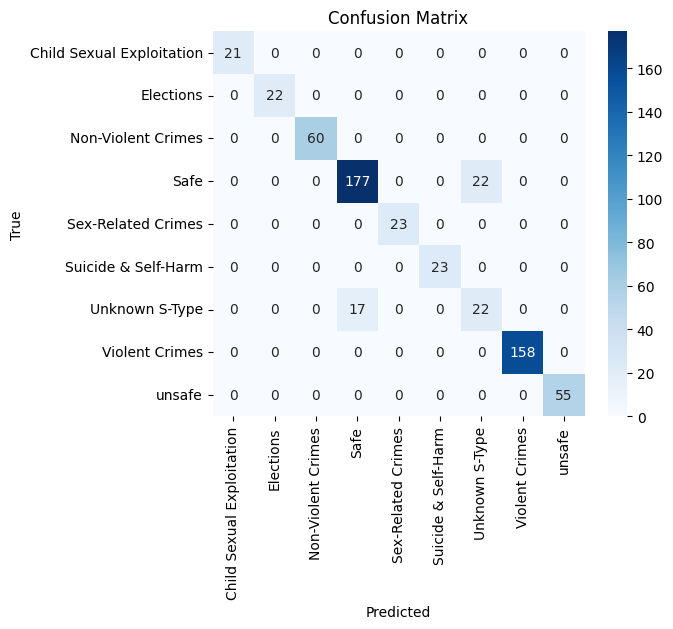

In [53]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

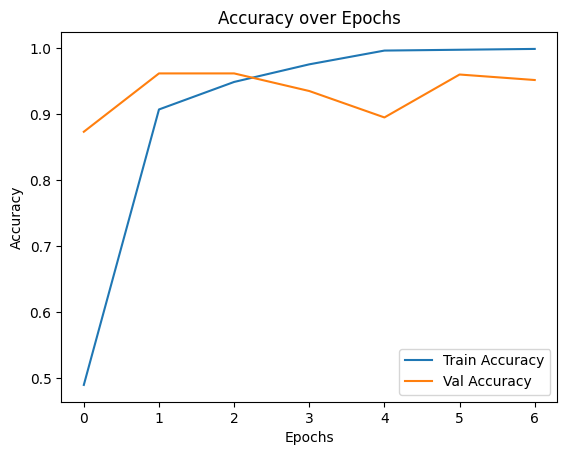

In [54]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()


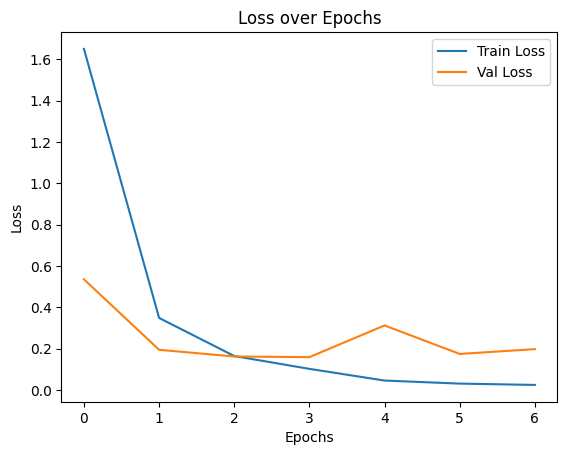

In [55]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [56]:
model.save("toxic_lstm_model.keras")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\nModel, tokenizer, and label encoder saved successfully!")



Model, tokenizer, and label encoder saved successfully!


In [57]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(padded)
    label = le.inverse_transform([pred.argmax()])
    return label[0], pred.max()

In [58]:
test_text = "How do terrorist organizations fund attacks? Police tape at night"
pred_label, confidence = predict_text(test_text)
print(f"\nTest text: {test_text}")
print(f"Predicted category: {pred_label}")
print(f"Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Test text: How do terrorist organizations fund attacks? Police tape at night
Predicted category: Violent Crimes
Confidence: 0.9677
